# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

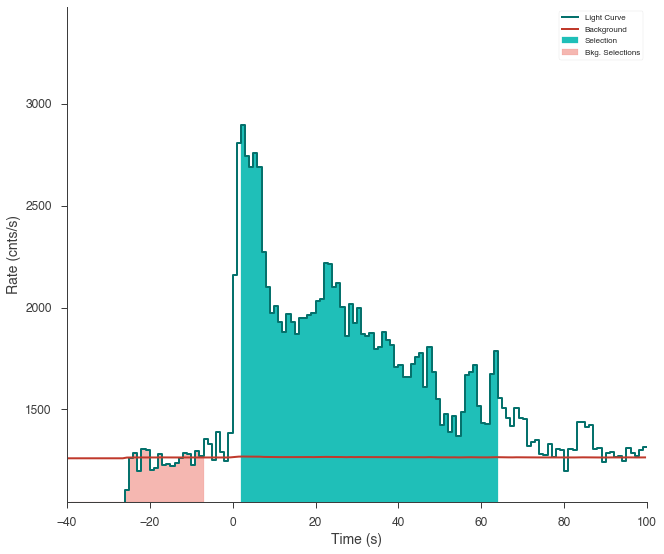

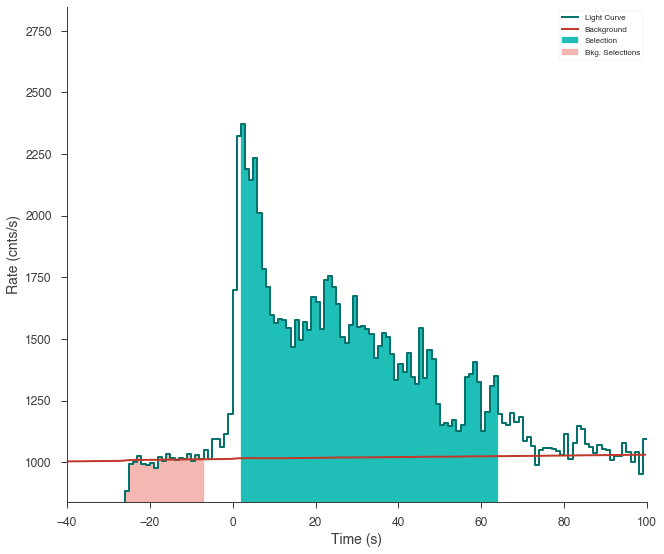

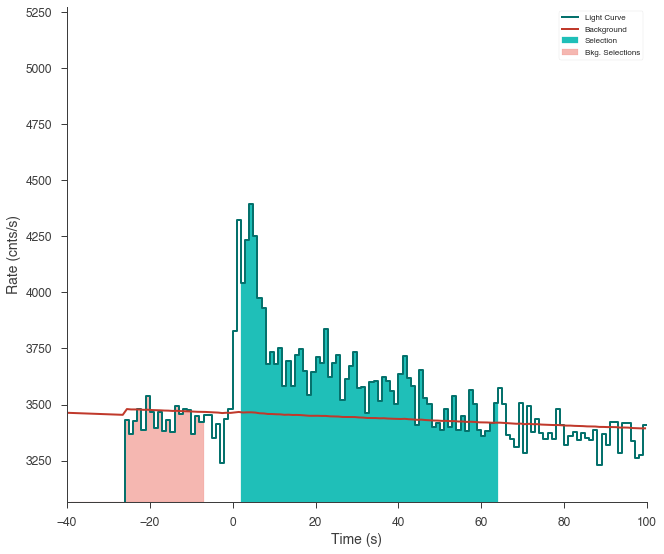

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

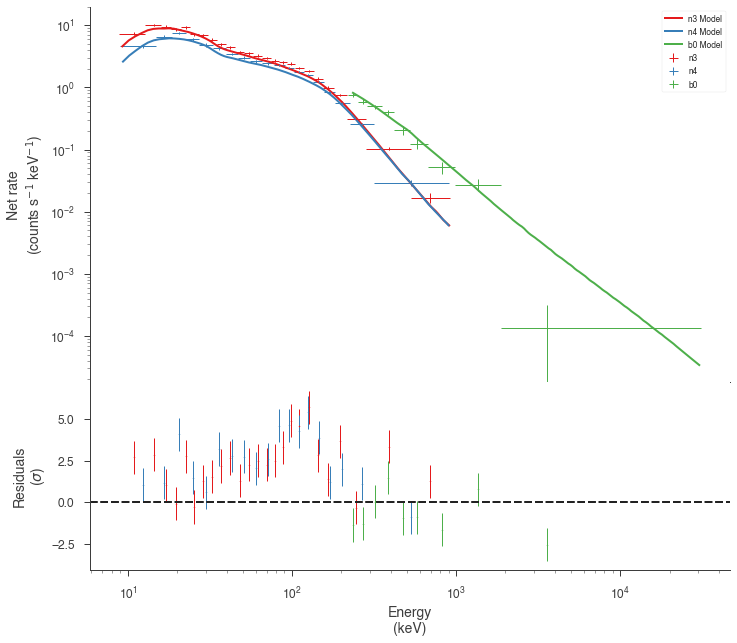

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB080916009...K,(1.469 -0.018 +0.017) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.074 +/- 0.014,
GRB080916009...break_energy,(2.17 -0.20 +0.21) x 10^2,keV
GRB080916009...break_scale,(2.0 -0.6 +0.7) x 10^-1,
GRB080916009...beta,-2.11 +/- 0.07,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-1051.713225
n3,-1023.332509
n4,-1014.332898
total,-3089.378631



Values of statistical measures:



,statistical measures
AIC,6188.927717
BIC,6208.159927
DIC,6175.160472
PDIC,3.865654
log(Z),-1347.682595


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************
 ln(ev)=  -3103.1538537976189      +/-  0.22445454002295467     
 Total Likelihood Evaluations:        25603
 Sampling finished. Exiting MultiNest


Now our model seems to match much better with the data!

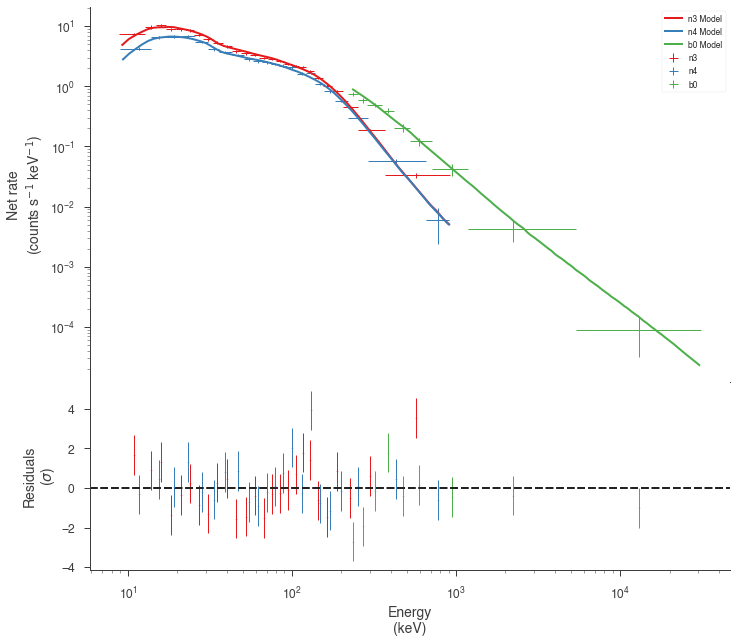

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid ** 2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

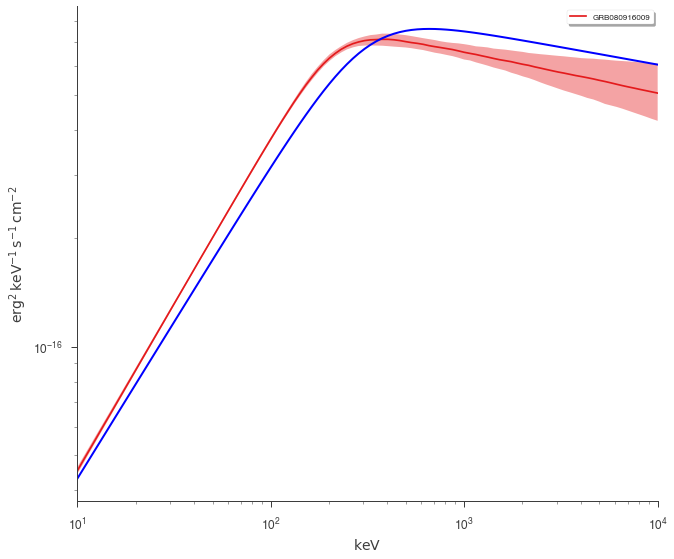

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


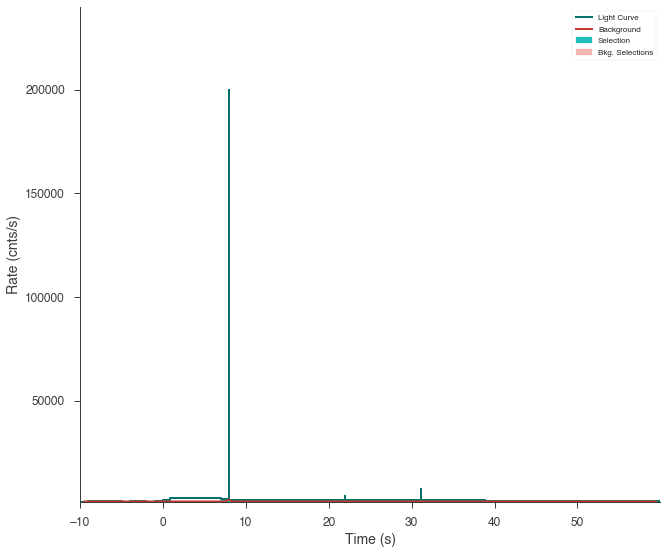

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

Now our light curve looks much more acceptable.

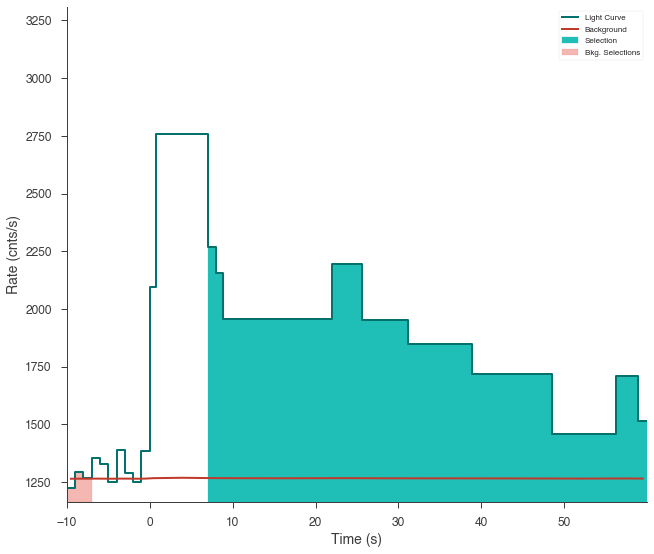

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.6 +/- 0.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.4 +/- 1.3) x 10^-1,
grb.spectrum.main.Band.xp,(3.2 +/- 0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.19 -0.20 +0.21,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval0,-280.496746
n3_interval0,-245.027352
n4_interval0,-261.510846
total,-787.034944



Values of statistical measures:



,statistical measures
AIC,1582.183203
BIC,1597.592021
DIC,1560.247341
PDIC,2.182694
log(Z),-343.020020


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(6.74 +/- 0.06) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.11 -0.11 +0.12) x 10^-1,
grb.spectrum.main.Band.xp,(2.74 +/- 0.05) x 10^2,keV
grb.spectrum.main.Band.beta,-1.824 -0.023 +0.024,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval1,-680.660860
n3_interval1,-651.654474
n4_interval1,-645.440071
total,-1977.755405



Values of statistical measures:



,statistical measures
AIC,3963.624124
BIC,3979.032942
DIC,3944.123474
PDIC,2.491824
log(Z),-864.190741


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.51 -0.18 +0.17) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.07 +/- 0.06,
grb.spectrum.main.Band.xp,(6.7 +/- 1.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.54 -0.25 +0.24,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval2,-317.214409
n3_interval2,-283.254606
n4_interval2,-306.528826
total,-906.997841



Values of statistical measures:



,statistical measures
AIC,1822.108996
BIC,1837.517814
DIC,1791.779095
PDIC,2.645849
log(Z),-394.266858


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.99 -0.25 +0.33) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-6.98 -0.11 +0.6) x 10^-1,
grb.spectrum.main.Band.xp,(2.48 +/- 0.23) x 10^2,keV
grb.spectrum.main.Band.beta,-2.3505 -0.12 +0.0032,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval3,-291.477456
n3_interval3,-237.791987
n4_interval3,-258.784675
total,-788.054118



Values of statistical measures:



,statistical measures
AIC,1584.221550
BIC,1599.630368
DIC,1564.353115
PDIC,2.359135
log(Z),-345.502194


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.16 -0.11 +0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.5 +/- 0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.56 -0.4 +0.35) x 10^2,keV
grb.spectrum.main.Band.beta,-1.93 -0.04 +0.05,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval4,-773.523322
n3_interval4,-751.153600
n4_interval4,-741.383304
total,-2266.060226



Values of statistical measures:



,statistical measures
AIC,4540.233767
BIC,4555.642585
DIC,4520.919247
PDIC,3.084912
log(Z),-987.963777


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.99 -0.14 +0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.6 +/- 0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.68 -0.30 +0.27) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.13 +0.12,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval5,-531.267328
n3_interval5,-517.979708
n4_interval5,-522.775881
total,-1572.022917



Values of statistical measures:



,statistical measures
AIC,3152.159149
BIC,3167.567966
DIC,3131.064573
PDIC,2.970542
log(Z),-685.438679


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.64 -0.21 +0.26) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.5 -0.8 +0.9) x 10^-1,
grb.spectrum.main.Band.xp,(2.36 -0.23 +0.14) x 10^2,keV
grb.spectrum.main.Band.beta,-1.813 +/- 0.020,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval6,-611.009546
n3_interval6,-582.208565
n4_interval6,-571.151526
total,-1764.369637



Values of statistical measures:



,statistical measures
AIC,3536.852588
BIC,3552.261405
DIC,3522.559646
PDIC,3.535655
log(Z),-771.388550


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.70 -0.09 +0.10) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.03 +/- 0.04,
grb.spectrum.main.Band.xp,(4.2 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.55 -0.30 +0.29,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval7,-659.317819
n3_interval7,-635.283466
n4_interval7,-644.295028
total,-1938.896313



Values of statistical measures:



,statistical measures
AIC,3885.905941
BIC,3901.314758
DIC,3863.512000
PDIC,3.075826
log(Z),-844.122463


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.59 +/- 0.12) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.2 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.6 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.53 +/- 0.28,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval8,-696.903515
n3_interval8,-693.567916
n4_interval8,-661.187261
total,-2051.658693



Values of statistical measures:



,statistical measures
AIC,4111.430700
BIC,4126.839517
DIC,4090.310392
PDIC,3.125346
log(Z),-893.084928


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.3 +/- 0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.3 +/- 2.1) x 10^-1,
grb.spectrum.main.Band.xp,(1.3 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.14 -0.32 +0.31,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval9,-646.980255
n3_interval9,-615.063196
n4_interval9,-613.737991
total,-1875.781442



Values of statistical measures:



,statistical measures
AIC,3759.676198
BIC,3775.085015
DIC,3732.694559
PDIC,-12.905587
log(Z),-816.883247


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.0 +/- 0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.5 +/- 1.2) x 10^-1,
grb.spectrum.main.Band.xp,(2.3 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.25 -0.35 +0.32,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval10,-457.056847
n3_interval10,-433.979927
n4_interval10,-429.239667
total,-1320.276442



Values of statistical measures:



,statistical measures
AIC,2648.666198
BIC,2664.075015
DIC,2630.908522
PDIC,2.260215
log(Z),-575.178364


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.4 -1.3 +1.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.1 -2.3 +2.5) x 10^-1,
grb.spectrum.main.Band.xp,(1.28 +/- 0.25) x 10^2,keV
grb.spectrum.main.Band.beta,-2.26 -0.30 +0.31,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval11,-289.650278
n3_interval11,-268.966072
n4_interval11,-252.543195
total,-811.159544



Values of statistical measures:



,statistical measures
AIC,1630.432403
BIC,1645.841221
DIC,1613.278609
PDIC,1.044006
log(Z),-353.362303


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -789.83278440156766      +/-  0.17673022880264058     
 Total Likelihood Evaluations:        17078
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1989.8727179481168      +/-  0.21821956894303249     
 Total Likelihood Evaluations:        22085
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

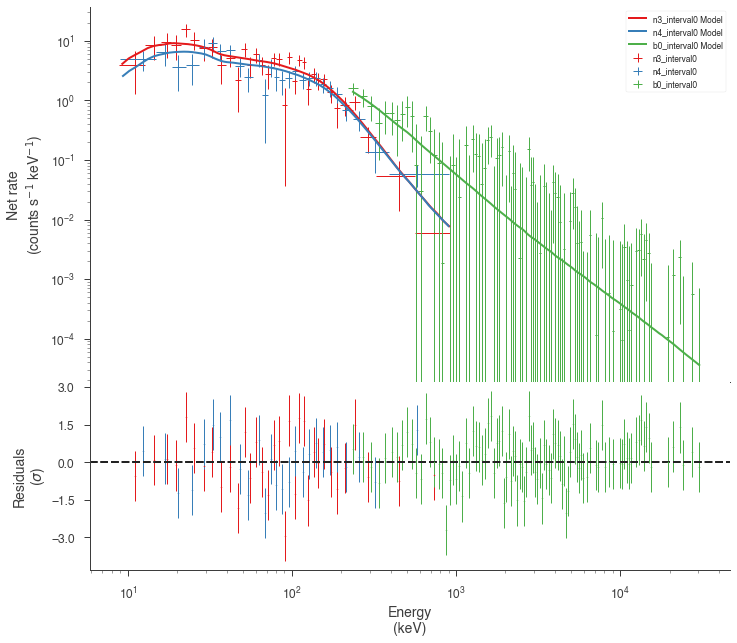

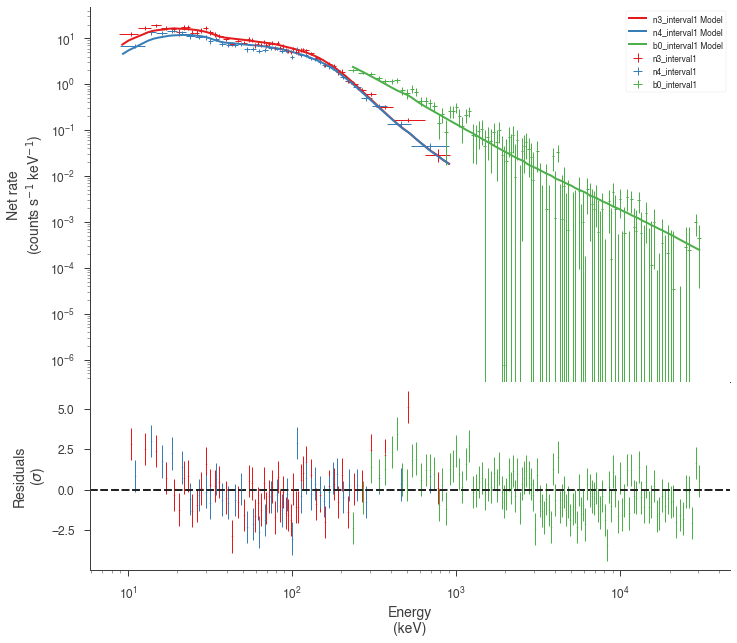

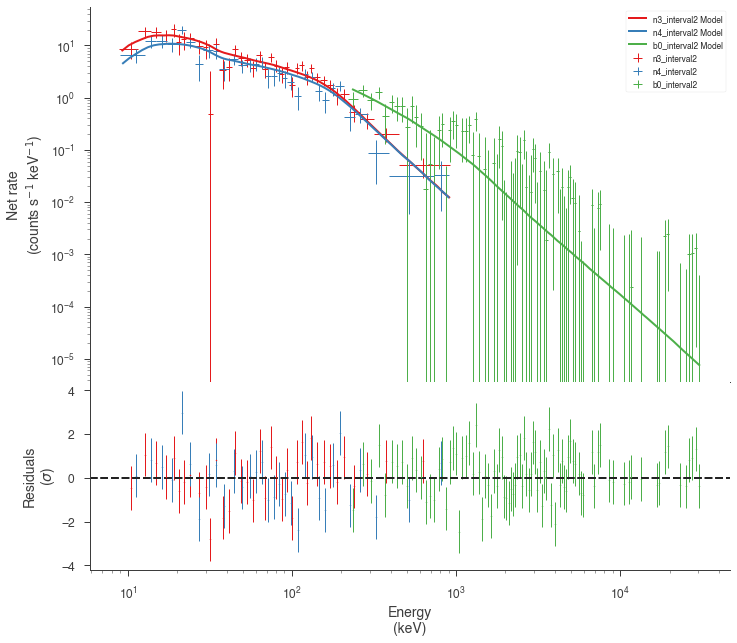

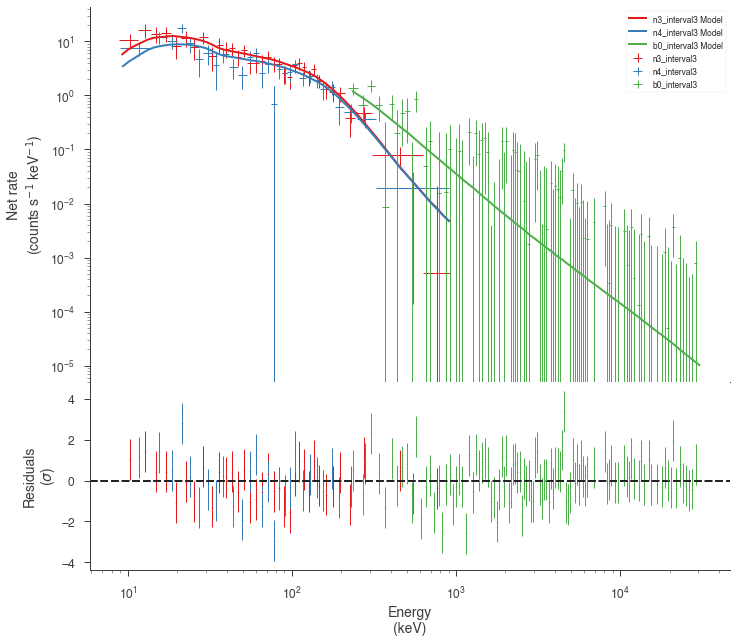

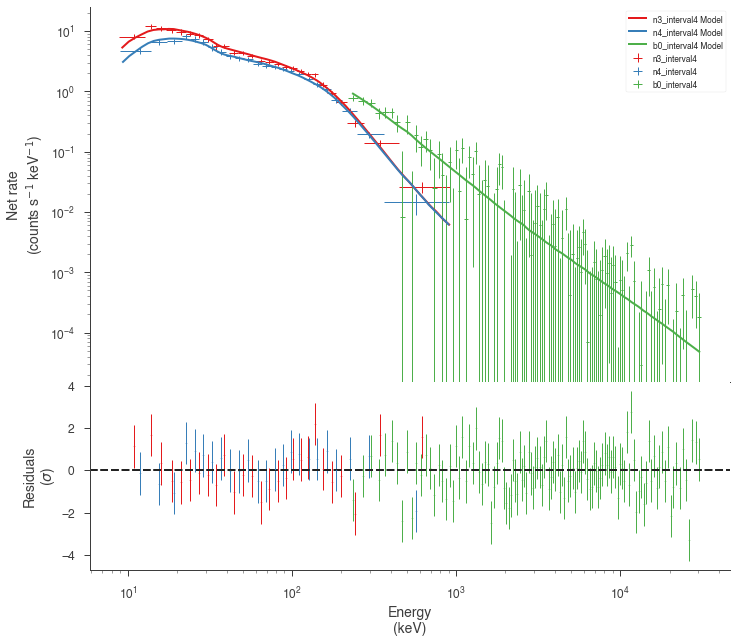

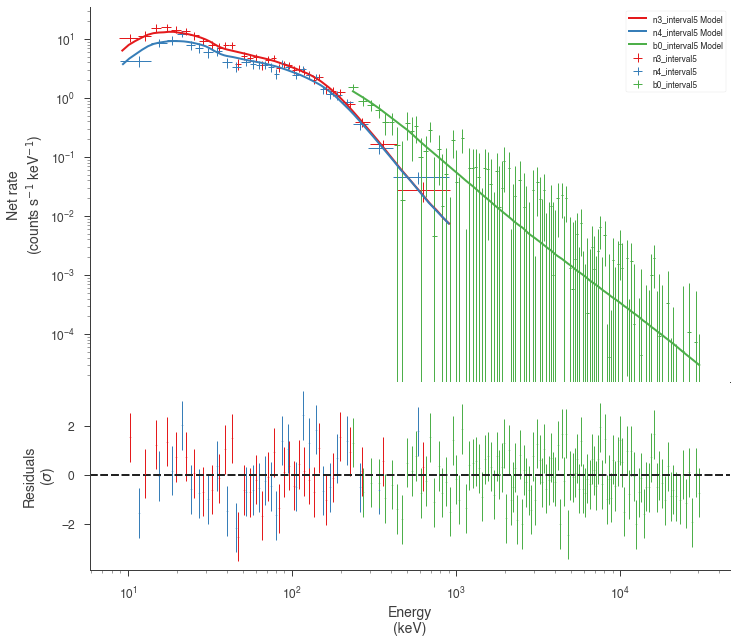

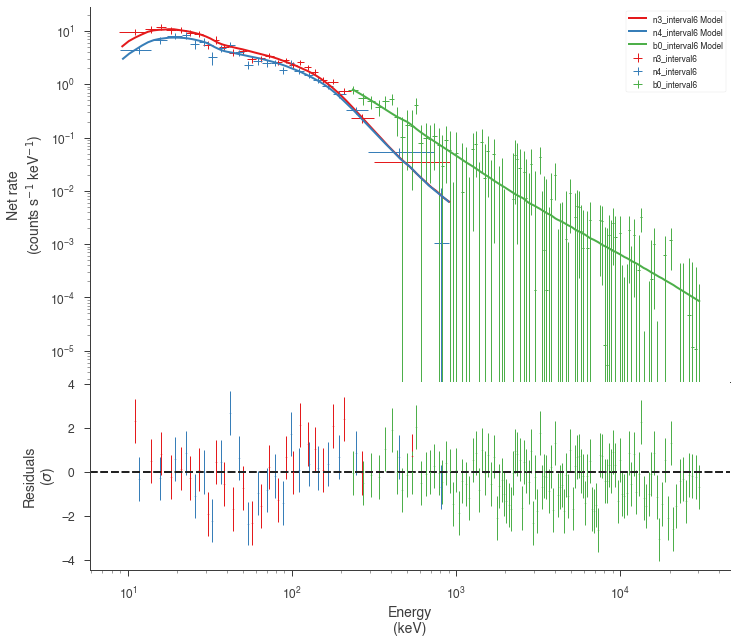

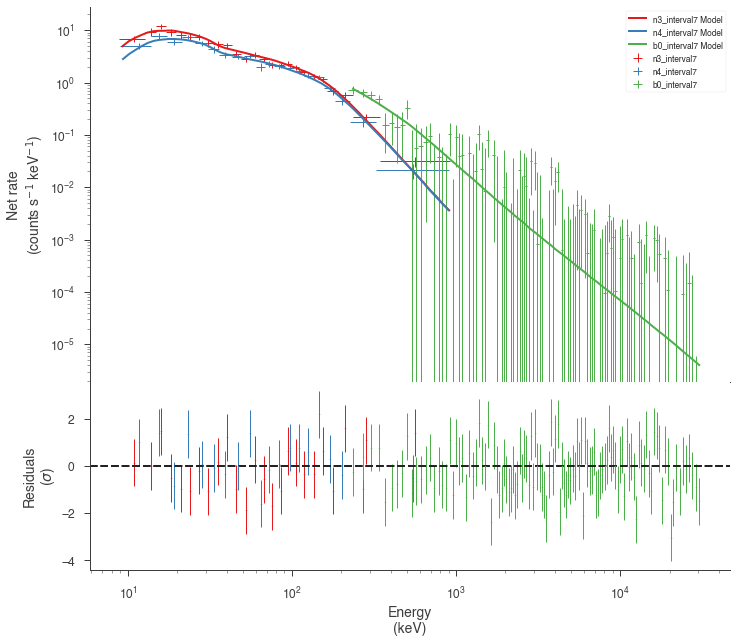

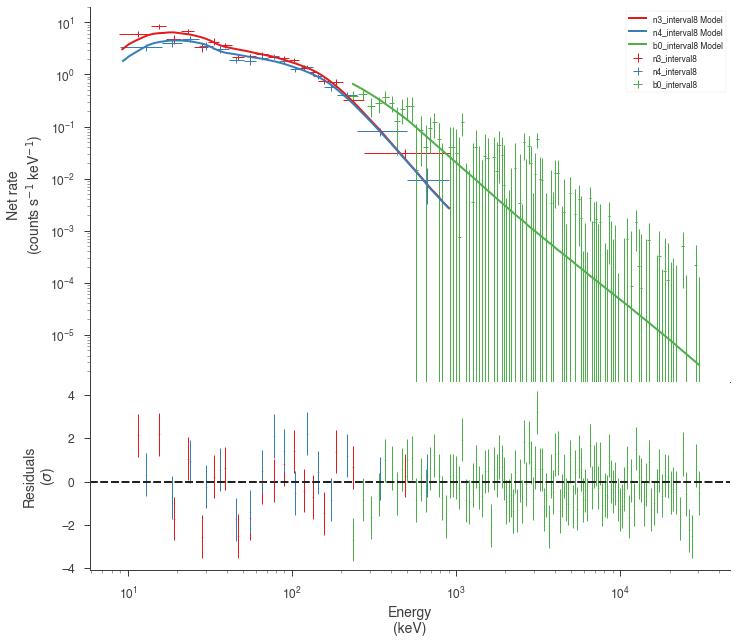

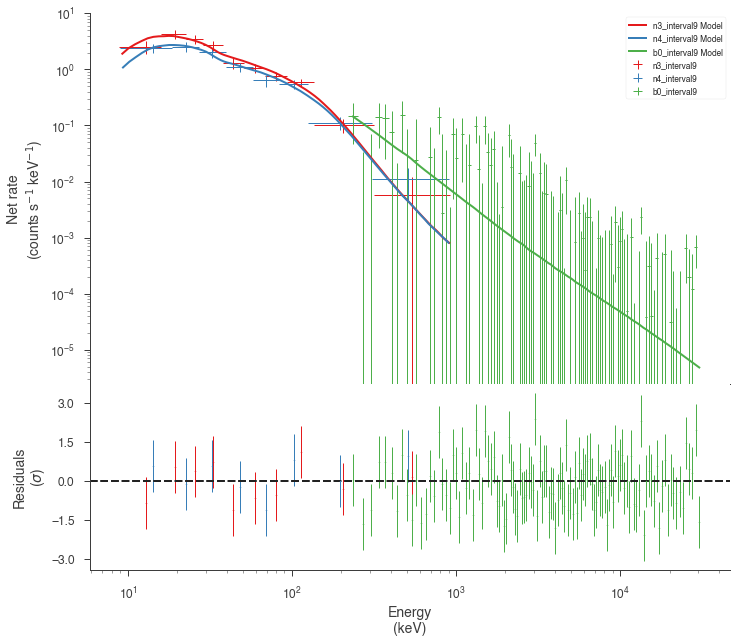

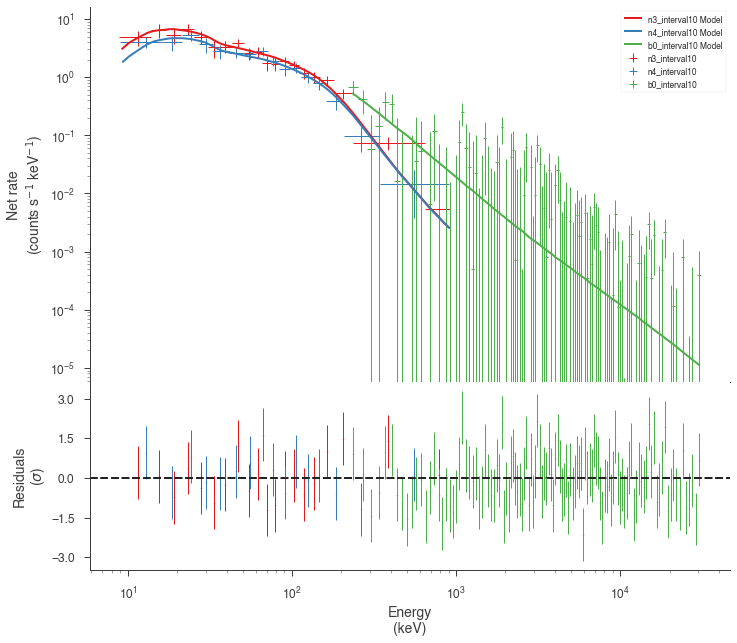

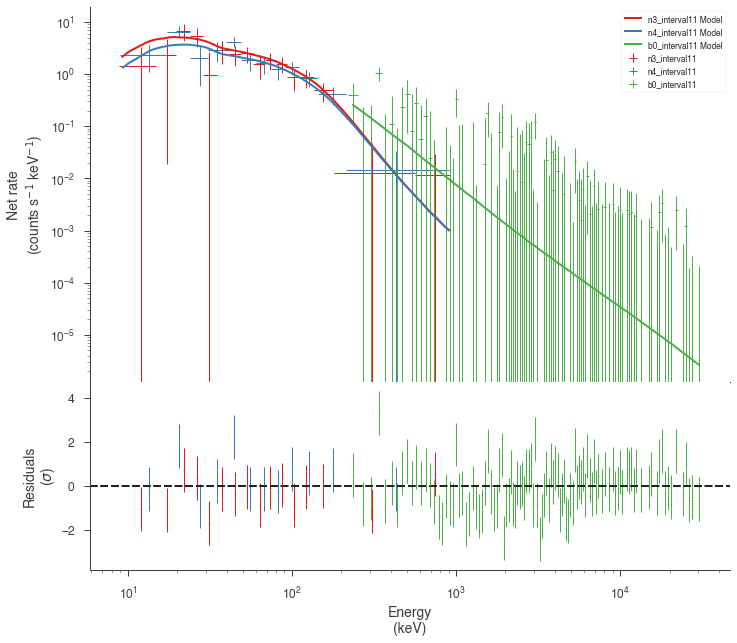

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, -99], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

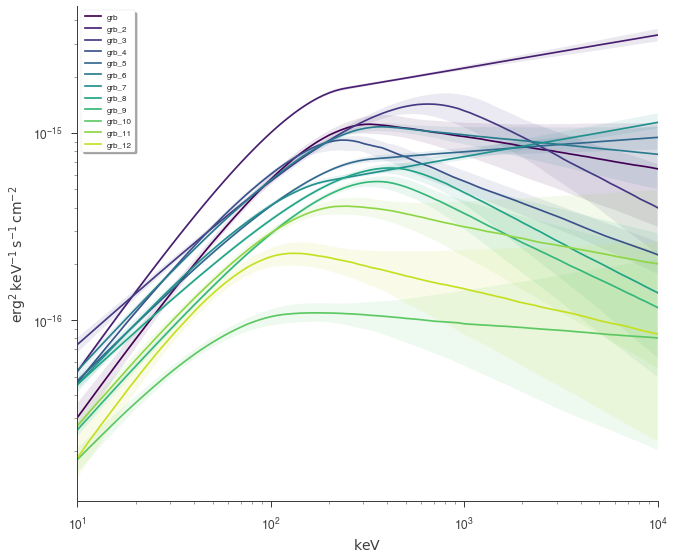

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.